In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [2]:
import scipy.signal as si

In [3]:
import pysm3
import pysm3.units as usm

In [4]:
import skytools

In [5]:
import astropy.units as u 

In [6]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [7]:
#os.environ

In [8]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  238.229 GB
     percent :   52.700 % 
        used :  211.268 GB
        free :  173.832 GB
        free :  174.282 GB (after GC)
      active :   70.741 GB
    inactive :  137.941 GB
    inactive :  137.480 GB (after GC)
     buffers :   66.734 MB
      cached :  117.973 GB
      cached :  117.526 GB (after GC)
      shared :   25.255 GB
      shared :   25.282 GB (after GC)
        slab :   39.401 GB
        slab :   39.359 GB (after GC)



0. Read Planck map

In [9]:
NSIDE = 512
lmax = 2*NSIDE

In [10]:
amin2rad = np.pi/(60*180)

fwhm_spsat = 72.8*amin2rad

fwhm_planck = 35*amin2rad

fwhm_planck

bl_spsat = hp.gauss_beam(fwhm=fwhm_spsat,lmax=lmax,pol=True)
bl_planck = hp.gauss_beam(fwhm=fwhm_planck,lmax=lmax,pol=True)


In [11]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates


In [12]:
truesky_GC512 = hp.read_map(filename='cmb_030_GC_nside.FITS',field=None)

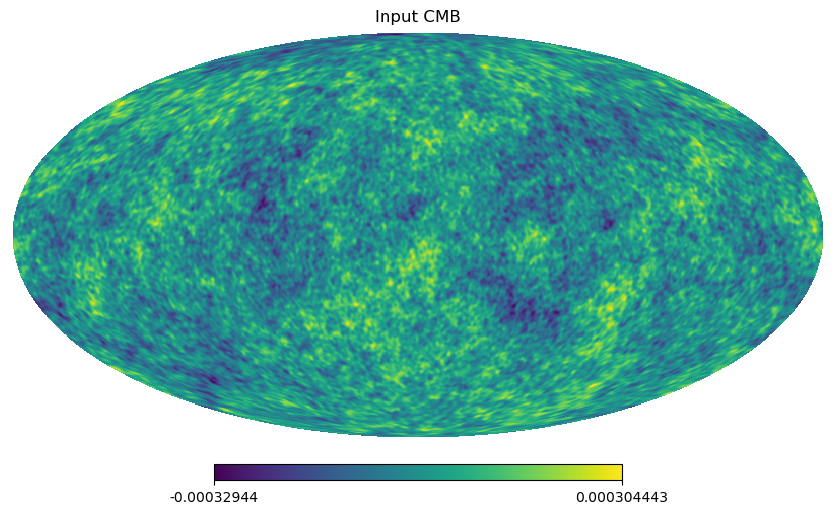

In [13]:
hp.mollview(truesky_GC512[0],title = 'Input CMB')

In [14]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [15]:
l_arr = np.arange(0,lmax+1)

Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [136]:
from toast.qarray import to_iso_angles, rotation, mult
xrot = rotation([0,1,0], np.pi/2)


In [137]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

In [138]:
with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

Print focalplane information

In [102]:
for detec in focalplane.detectors:
    q = focalplane[detec]["quat"]
    print(np.degrees(to_iso_angles(mult(xrot,q))))

[88.08882932  1.94993571 22.5       ]
[ 88.08882932   1.94993571 112.5       ]
[90.          3.05321419 67.5       ]
[ 90.           3.05321419 157.5       ]
[90.          0.84665724 67.5       ]
[ 90.           0.84665724 157.5       ]
[91.91117068  1.94993571 22.5       ]
[ 91.91117068   1.94993571 112.5       ]
[ 88.89786687   7.17209843 -97.5670297 ]
[88.89786687  7.17209843 -7.5670297 ]
[ 88.89628048   4.96503074 -52.50613882]
[88.89628048  4.96503074 37.49386118]
[ 86.9857875    6.06983805 -52.54583908]
[86.9857875   6.06983805 37.45416092]
[ 86.98572831   3.86012121 -97.44803143]
[86.98572831  3.86012121 -7.44803143]
[ 93.01427169   3.86012121 142.44803143]
[  93.01427169    3.86012121 -127.55196857]
[  91.10371952    4.96503074 -172.49386118]
[ 91.10371952   4.96503074 -82.49386118]
[  93.0142125     6.06983805 -172.45416092]
[ 93.0142125    6.06983805 -82.45416092]
[ 91.10213313   7.17209843 142.5670297 ]
[  91.10213313    7.17209843 -127.4329703 ]
[83.78902672 -5.58231042 22.

In [141]:
q1 = focalplane['029_000_SAT_f030_A']["quat"]
q2 = focalplane['040_000_SAT_f030_A']["quat"]
print(np.degrees(to_iso_angles(mult(xrot,q1))))
print(np.degrees(to_iso_angles(mult(xrot,q2))))


[88.08882932  1.94993571 22.5       ]
[ 88.08882932 -13.04167763  22.5       ]


Define the schedule, site and telescope

In [143]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0,
  '040_000_SAT_f030_A': 228}
#=focalplane._det_to_row[:4]

In [144]:
focalplane._det_to_row

{'029_000_SAT_f030_A': 0, '040_000_SAT_f030_A': 228}

In [145]:
schedule = toast.schedule.GroundSchedule()
#for i in range(7):
#    schedule.read("POLE_DEEP-169-"+str(i+1)+".txt", comm=comm)
schedule.read("POLE_DEEP-169-1.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP-169-1.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP-169-1.txt totaling 84.0 minutes.


Print schedule information

In [146]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
>

Print telescope information

In [147]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

In [148]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_000_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [149]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [150]:
data = toast.Data(comm=toast_comm)

In [151]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [152]:
sim_ground

<SimGround
  API = 0 # Internal interface version for this operator
  azimuth = azimuth # Observation shared key for Azimuth
  boresight_azel = boresight_azel # Observation shared key for boresight AZ/EL
  boresight_radec = boresight_radec # Observation shared key for boresight RA/DEC
  det_data = signal # Observation detdata key to initialize
  det_data_units = K # Output units if creating detector data
  det_flags = flags # Observation detdata key for flags to initialize
  detset_key = pixel # If specified, use this column of the focalplane detector_data to group detectors
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  el_mod_amplitude = 1.0 deg # Range of elevation modulation
  el_mod_rate = 0.0 Hz # Modulate elevation continuously at this rate
  el_mod_sine = False # Modulate elevation with a sine wave instead of a triangle wave
  el_mod_step = 0.0 deg # Amount to step elevation after each left-right scan pair
  elevation = e

In [153]:
sim_ground.apply(data)

In [154]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_000_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  50400 total samples (50400 local)
  shared:  <SharedDataManager
    times (column): shape=(50400,),

In [155]:
focalplane.detectors

['029_000_SAT_f030_A', '040_000_SAT_f030_A']

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [156]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "IQU")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

In [157]:
pointing.apply(data)

In [158]:
scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='cmb_030_GC_nside.FITS',pixel_pointing = pixels, stokes_weights = weights)
scan_map.apply(data)

TOAST INFO: Pixel data in cmb_030_GC_nside.FITS does not have TUNIT1 key.  Assuming 'K'.


2. Noise simulation

In [159]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [160]:
noise_model.apply(data) ## Read detector noise from the focalplane

In [161]:
step_0 = 4*u.second


In [162]:
ob = data.obs[0]

In [163]:
ob.detdata['quats'][0].shape

(50400, 4)

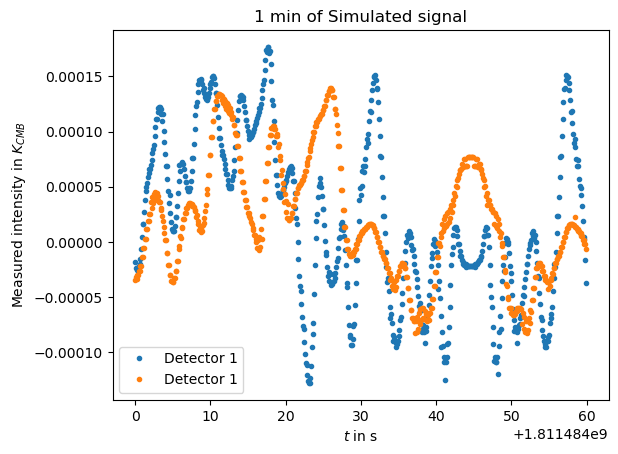

In [164]:
plt.plot(ob.shared["times"][0:600],ob.detdata["signal"][0][0:600],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["signal"][1][0:600],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [165]:
quats_1 = ob.detdata['quats'][0]
quats_2 = ob.detdata['quats'][1]

In [166]:
#iso_ang1 = np.degrees(to_iso_angles(mult(xrot,quats_1)))
#iso_ang2 = np.degrees(to_iso_angles(mult(xrot,quats_2)))
iso_ang1 = to_iso_angles(mult(xrot,quats_1))
iso_ang2 = to_iso_angles(mult(xrot,quats_2))

In [167]:
iso_ang1

(array([2.24586419, 2.24622195, 2.24657314, ..., 1.68657489, 1.68837404,
        1.6901726 ]),
 array([-3.01574743, -3.01804424, -3.02034337, ...,  2.46302326,
         2.46329218,  2.46356523]),
 array([-1.0199492 , -1.02361139, -1.02727568, ..., -2.6432874 ,
        -2.64104088, -2.63879339]))

In [168]:
th1,phi1,psi1 = iso_ang1
th2,phi2,psi2 = iso_ang2


In [169]:
print(phi1)

[-3.01574743 -3.01804424 -3.02034337 ...  2.46302326  2.46329218
  2.46356523]


In [170]:
pix_arr1 = hp.ang2pix(nside=NSIDE,theta= th1, phi = phi1, lonlat = False)

In [171]:
pix_arr2 = hp.ang2pix(nside=NSIDE,theta= th2, phi = phi2, lonlat = False)

In [172]:
time = ob.shared["times"]

In [179]:
N_time = time.shape[0]
print(N_time)

50400


In [181]:
npix = hp.nside2npix(NSIDE)

In [182]:
npix

3145728

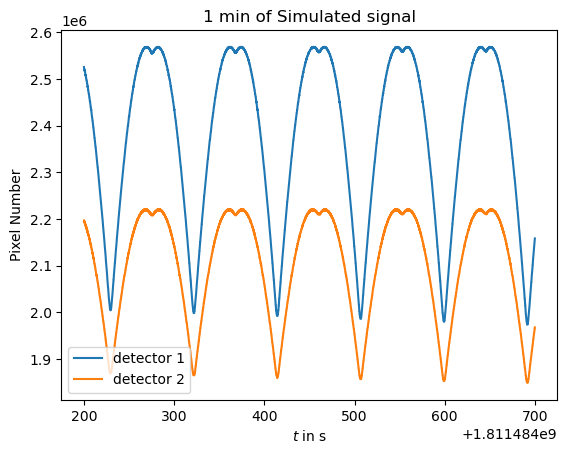

In [174]:
plt.plot(time[2000:7000], pix_arr1[2000:7000], label = 'detector 1')
plt.plot(time[2000:7000], pix_arr2[2000:7000], label = 'detector 2')
plt.xlabel('$t$ in s')
plt.ylabel('Pixel Number')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [176]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_000_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  noise_model = <AnalyticNoise model with 2 detectors>
  50400 total samples (50400 local)
  shared: 

## Create a pointing matrix

In [192]:
pointing_arr = np.zeros((2*N_time,3*npix),dtype = complex)

In [193]:
for t in range(N_time):
    for pol in range(3):
        pointing_arr[t, pol*pix_arr1[t]] = 1
        pointing_arr[t, pol*pix_arr1[t]+1] = np.cos(2*psi1[t])
        pointing_arr[t, pol*pix_arr1[t]+2] = np.sin(2*psi1[t])

In [194]:
pointing_arr.shape

(100800, 9437184)

In [195]:
print(pointing_arr)

[[ 1.        +0.j -0.45208554+0.j -0.89197459+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 1.        +0.j -0.45860652+0.j -0.88863944+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 1.        +0.j -0.46510661+0.j -0.88525467+0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]]
